# Model Training - Phasebased
This model architecture also takes phase information into account.

For that, the phases have to be normalized accordingly.

## Imports
This notebook uses the custom code found in the code folder

In [1]:
import os

# math, processing, deep learning
import numpy as np
import tensorflow as tf
from scipy.signal import stft, istft

# visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable


# custom code
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer

# convenience
from tqdm import tqdm
import datetime


2023-04-27 21:45:28.137767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the files for training and testing
There are different training and test sets in the folder. This section loads the appropriate ones into memory.


In [2]:
# this is a smaller training set for testing purposes
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# this is a training set for training the main model
# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


Load the files from the given locations using the custom code StftDataset class.

The StftDataset class also processes the waveforms into STFT format.

In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


Check the shape of the data

In [4]:
noisy_stft.get_data().shape

(10000, 129, 9, 2)

### Extracting phase and amplitude information
The StftDataset class loads the data that was stored in amplitude and phase format in different files and combines it together

In [75]:
# get the amplitudes of training and test sets
examples = noisy_stft.get_data()[:,:,:,:]
labels = pure_stft.get_data()[:,:,:,:]

stride_reduce = 100
examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,:]
labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,:]

# examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,1]
# labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,1]

# build the dataset from tensorflow functions
train_dataset = tf.data.Dataset.from_tensor_slices((examples, labels))
test_dataset = tf.data.Dataset.from_tensor_slices((examples_test, labels_test))

In [76]:
train_dataset
# test_dataset

<TensorSliceDataset shapes: ((129, 9, 2), (129, 9, 2)), types: (tf.float64, tf.float64)>

In [77]:
input_shape = examples.shape[1:]
# count up the number of elements in the data for the flattened layer
number_of_data_elements = np.prod(input_shape)

In [78]:
BATCH_SIZE = int(512/1)
SHUFFLE_BUFFER_SIZE = int(2000/1)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [79]:
# train_dataset.take(1).unbatch()
   

In [80]:
class Custom_Loss(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):        
        amplitude_mse = tf.reduce_mean(tf.math.square(y_pred[:,:,:,0] - y_true[:,:,:,0]))
        phase_mse = tf.reduce_mean(tf.math.square(y_pred[:,:,:,1] - y_true[:,:,:,1]))
        # return amplitude_mse + 0.0001*phase_mse
        return amplitude_mse 


# Define custom activation function for scaling
def scaling_activation(x):
    return 3.14 * tf.tanh(x)
    
def scaling_activation(x):
    amplitude_activation = 0
    phase_activation =0
    return 3.14 * tf.tanh(x)
    

In [81]:
dropout_rate = 0.05
factor = 1

model = tf.keras.Sequential([
     # this is normalization for amplitude and phase information, both separated on the last axis
    tf.keras.layers.experimental.preprocessing.Normalization(axis=-1, input_shape=input_shape),
    
    # tf.keras.layers.experimental.preprocessing.Normalization(axis=None,input_shape=input_shape),
    
    tf.keras.layers.Flatten(input_shape=input_shape),

    tf.keras.layers.Dense(units = 125*factor, activation='elu'),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units = 75*factor, activation='elu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 50*factor, activation='elu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),
    tf.keras.layers.Dense(units = 50*factor, activation='elu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),
    tf.keras.layers.Dense(units = 50*factor, activation='elu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 75*factor, activation='elu'),
    tf.keras.layers.Dropout(rate=dropout_rate),


    tf.keras.layers.Dense(units = number_of_data_elements, activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Conv2D(3,2, activation='relu', input_shape=input_shape),
    # tf.keras.layers.experimental.preprocessing.Rescaling(scale=3.14),
    tf.keras.layers.Reshape(target_shape=input_shape)
])

model.compile(optimizer="adam",
              loss=Custom_Loss(),
                # loss="mse"

              )

In [82]:
norm_layer = model.layers[0]

In [83]:
norm_layer.adapt(examples)

In [84]:
train_take_example = train_dataset.take(1)

In [85]:
# help(train_take_example)

In [86]:
examples.shape

(10000, 129, 9, 2)

In [87]:
norm_example = norm_layer(examples[0])

In [88]:
norm_example.shape

TensorShape([1, 129, 9, 2])

TypeError: Invalid shape (129, 9, 2) for image data

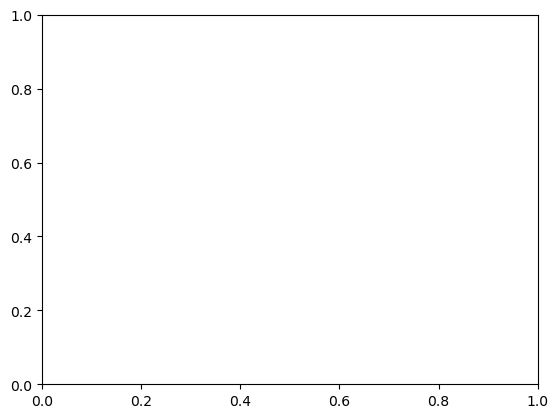

In [89]:
plt.imshow(norm_example[0,:,:], aspect="auto")
plt.colorbar()

In [90]:
# help(norm_layer)

In [91]:
# norm_layer(train_take_example)

In [92]:
norm_layer.variance

<tf.Variable 'normalization_3/variance:0' shape=(2,) dtype=float32, numpy=array([1.2994169e-04, 3.3512750e+00], dtype=float32)>

In [93]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 129, 9, 2)         5         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2322)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 125)               290375    
_________________________________________________________________
dropout_30 (Dropout)         (None, 125)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 75)                9450      
_________________________________________________________________
dropout_31 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)               

In [94]:
from tensorflow.keras.callbacks import Callback

class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if not self.params['verbose']:
            print("Loss: {}".format(logs['loss']))

In [95]:
model.fit(train_dataset,validation_data=test_dataset, epochs=100, callbacks=[LossCallback()], verbose=True)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 1s 23ms/step - loss: 0.0025 - val_loss: 1.1339e-04
Epoch 2/100
20/20 [==============================] - 0s 19ms/step - loss: 1.1782e-04 - val_loss: 1.0078e-04
Epoch 3/100
20/20 [==============================] - 0s 19ms/step - loss: 1.0747e-04 - val_loss: 9.3018e-05
Epoch 4/100
20/20 [==============================] - 0s 19ms/step - loss: 9.9600

## Looking at predictions
Inspecting the predictions of the model on the training set.

# Note: !!!!!!!!!!!!!!!!!!!!!
The normalization layer seems to be a problem.
Even with just the amplitude and the normalization layer the results are garbage. but not so bad for no normalization...

## Analysis
The problem seems to be that the normalization layer "overreacts" because of the low, near-zero values. They dominate the variance and therefore the normalization scales outliers beyond values of 1. The activation functions however do not react well to values above 1.

The amplitude and phase layer need different forms of normalizations. Scaling the amplitude linearly is a problem.

They also would need to be reversible.

It would be a good idea to create custom layers.



In [130]:
# release train dataset:
# train_dataset = None
# test_dataset = None
example_count = 2
train_example_data = train_dataset.take(count=example_count)
train_example_data = train_example_data.unbatch()
predictions = model.predict(train_example_data)

In [144]:
train_example_data

<_UnbatchDataset shapes: ((129, 9, 2), (129, 9, 2)), types: (tf.float64, tf.float64)>

In [146]:
# help(train_example_data)
train_example_data_list = []
# Get the tensors from the dataset
iterator = train_example_data.as_numpy_iterator()
# Iterate over the tensors in the dataset
for tensor in iterator:
    train_example_data_list.append(tensor)

In [149]:
train_example_data_tensor = tf.constant(train_example_data_list)

In [160]:
pure_train_examples = train_example_data_tensor[:,1,:,:,:]
noisy_train_examples = train_example_data_tensor[:,0,:,:,:]

In [161]:
predictions = model.predict(noisy_train_examples)

In [162]:
def plot_amp_example(index):
    
    fig, [ax0, ax1] = plt.subplots(1,2)

    divider0 = make_axes_locatable(ax0)
    divider1 = make_axes_locatable(ax1)

    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)


    # plt.imshow(labels[0,:,:,1], aspect="auto")
    im0 = ax0.imshow(pure_train_examples[index,:,:,0], aspect="auto")
    im1 = ax1.imshow(predictions[index,:,:,0], aspect="auto")
    # ax0.colorbar()
    # fig.colorbar(im1, cax=ax0_cb, orientation='horizontal')

    fig.colorbar(im0, cax=cax0, orientation='vertical')
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    ax0.set_title("Original target")
    ax1.set_title("Denoised result")

    fig.set_size_inches((10,5))
    # plt.imshow(predictions[0,:,:,1], aspect="auto")
    # ax1.imshow(predictions[0,:,:], aspect="auto")

    # plt.colorbar()

In [163]:
interact(plot_amp_example, index=(0, predictions.shape[0]-1, 1))

interactive(children=(IntSlider(value=511, description='index', max=1023), Output()), _dom_classes=('widget-in…

<function __main__.plot_amp_example(index)>

In [158]:
def plot_phase_example(index):
    fig, [ax0, ax1] = plt.subplots(1,2)

    divider0 = make_axes_locatable(ax0)
    divider1 = make_axes_locatable(ax1)

    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)


    # plt.imshow(labels[0,:,:,1], aspect="auto")
    im0 = ax0.imshow(labels[index,:,:,1], aspect="auto")
    im1 = ax1.imshow(predictions[index,:,:,1], aspect="auto")
    # ax0.colorbar()
    # fig.colorbar(im1, cax=ax0_cb, orientation='horizontal')

    fig.colorbar(im0, cax=cax0, orientation='vertical')
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    ax0.set_title("Original target")
    ax1.set_title("Denoised result")

    fig.set_size_inches((10,5))
    # plt.imshow(predictions[0,:,:,1], aspect="auto")
    # ax1.imshow(predictions[0,:,:], aspect="auto")

    # plt.colorbar()

In [159]:
interact(plot_phase_example, index=(0, 80, 1))

interactive(children=(IntSlider(value=40, description='index', max=80), Output()), _dom_classes=('widget-inter…

<function __main__.plot_phase_example(index)>

In [88]:
np.var(predictions)

0.047275927

In [89]:
predictions.shape

(1024, 129, 9, 2)

In [49]:
predictions.shape

def plot_example(index):
    prediction = predictions[index]
    actual = labels[index]
    noisy = examples[index]
    
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4)

    ax1.imshow(noisy, aspect="auto")
    ax1.set_title("Noisy Original")
    
    ax2.set_title("Denoised result")
    ax2.imshow(prediction, aspect = "auto")
    
    ax3.set_title("Actual ground truth")
    ax3.imshow(actual, aspect= "auto")
    ax4.imshow(actual-prediction, aspect="auto")
    
    fig.set_size_inches((10,5))
    
    plt.show()

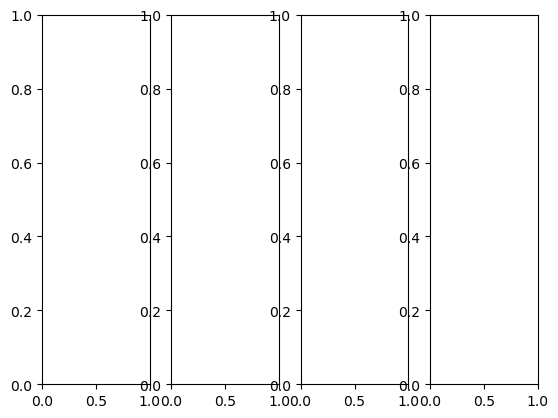

interactive(children=(IntSlider(value=10, description='index', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.plot_example(index)>

In [50]:
interact(plot_example, index=(0, 20, 1))

In [155]:
def plot_time_domain( index):

    test_noisy = noisy_stft.get_data()[index,:,:,0]
    test_noisy_phase = noisy_stft.get_data()[index,:,:,1]

    test_pure = labels[index,:,:]
    test_pure_phase = noisy_stft.get_data()[index,:,:,1]

    model_amp = predictions[index]
    noisy_phase = noisy_stft.get_data()[index,:,:,1]

    fig, [ax1, ax2] =plt.subplots(1,2)
    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_model = istft(model_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

    fig.set_size_inches((12,10))
    ax1.plot(t,signal_example)
    ax2.plot(t, signal_model)
    ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

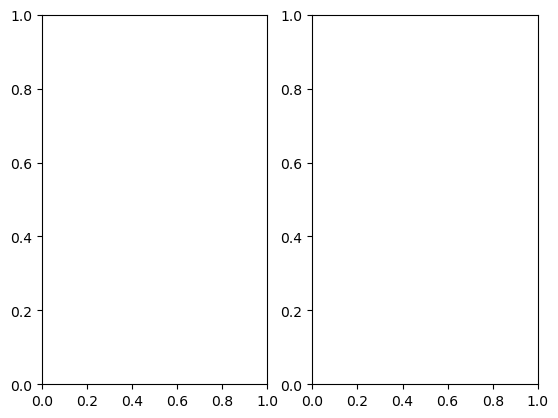

interactive(children=(IntSlider(value=512, description='index', max=1024), Output()), _dom_classes=('widget-in…

<function __main__.plot_time_domain(index)>

In [157]:
interact(plot_time_domain, index = (0,1024,1))

## Visualize the effect on the test set
Previous visualizations were for the training set only.

Check the influence of the test set here.

In [122]:
predictions_test = model.predict(examples_test)

In [123]:
# examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,:]
# labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,:]

# examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,:]
# labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,:]

In [124]:
predictions_test.shape

(1078, 129, 9, 2)

In [125]:
labels_test.shape

(1078, 129, 9, 2)

In [126]:
index = 10
prediction_current = predictions_test[index]
    
# the pure example from the test set
test_pure = labels_test[index]

pred_amp = prediction_current[:,:,0]
pred_phase = prediction_current[:,:,1]

In [127]:
pred_amp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [128]:
def plot_time_domain_test( index):

    # get the noisy original from the test set
    noisy_original = examples_test[index]
    
    # get the test set prediction
    prediction_current = predictions_test[index]
    
    # the pure example from the test set
    test_pure = labels_test[index]

    noisy_amp = noisy_original[:,:,0]
    noisy_phase = noisy_original[:,:,1]
    
    pred_amp = prediction_current[:,:,0]
    pred_phase = prediction_current[:,:,1]
    
    true_amp = test_pure[:,:,0]
    true_phase = test_pure[:,:,1]
    
    # model_amp = predictions_test[index]
    # noisy_phase = examples_test_phase[index]

    # calculate the STFT inverse of the deep learning predictions and the actual result
    # t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    
    t, signal_original = istft(noisy_amp*np.exp(1j*noisy_phase), fs = 1./5.)

    t, signal_pred = istft(pred_amp*np.exp(1j*pred_phase), fs = 1./5.)
    # t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)  
    
    t, signal_pred_origphase = istft(pred_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    
    t, signal_true = istft(true_amp*np.exp(1j*true_phase), fs = 1./5.)

    
    fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] =plt.subplots(2,3)

    fig.set_size_inches((12,10))
    ax1.plot(t, signal_original)
    ax1.set_title("Noisy example")

    ax2.plot(t, signal_pred)
    ax2.set_title("Denoised result")
    
    ax3.plot(t, signal_true)
    ax3.set_title("True original")
    
    ax5.plot(t, signal_pred_origphase)
    
    ax6.plot(t, signal_true)
    ax6.set_title("True original")

    # ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [129]:
num_test_examples = examples_test.shape[0]
interact(plot_time_domain_test, index = (0,num_test_examples,1))

interactive(children=(IntSlider(value=539, description='index', max=1078), Output()), _dom_classes=('widget-in…

<function __main__.plot_time_domain_test(index)>

## Store the model
Storing the model after a long training session.

In [46]:
model_folder = "model/"

In [47]:

# Get the current date
now = datetime.datetime.now()

# Format the date as "day-month-year"
date_str = now.strftime("%d-%m-h%H%M")

# 

# Parameter count
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])


model_name = f"model-{date_str}-p{trainableParams}-withphase"

In [48]:
store_model = False
if store_model == True:
    path = model_folder + model_name
    model.save(path)

## Analysis of maximum values
Looking at maximum values of amplitude over the whole array

In [52]:
test_example = noisy_stft.get_data()[0]
shape = test_example.shape
test_example_reshaped = noisy_stft.get_data()[0].reshape((1, shape[0], shape[1], shape[2]))

test_pure = pure_stft.get_data()[0]

In [53]:
test_pure[:,:,0].max()

0.1167289817731223

Todo
Normalize the phase and amplitude values..

In [54]:
amps_noisy =noisy_stft.get_data()[:,:,:,0]

In [55]:
amps_noisy_flattened = amps_noisy.flatten()

(array([1.0101877e+07, 1.1225070e+06, 1.9600700e+05, 1.0042300e+05,
        5.1438000e+04, 2.1964000e+04, 9.8380000e+03, 4.6260000e+03,
        1.1690000e+03, 1.5100000e+02]),
 array([2.14359953e-11, 1.67539747e-02, 3.35079495e-02, 5.02619242e-02,
        6.70158989e-02, 8.37698737e-02, 1.00523848e-01, 1.17277823e-01,
        1.34031798e-01, 1.50785773e-01, 1.67539747e-01]),
 <BarContainer object of 10 artists>)

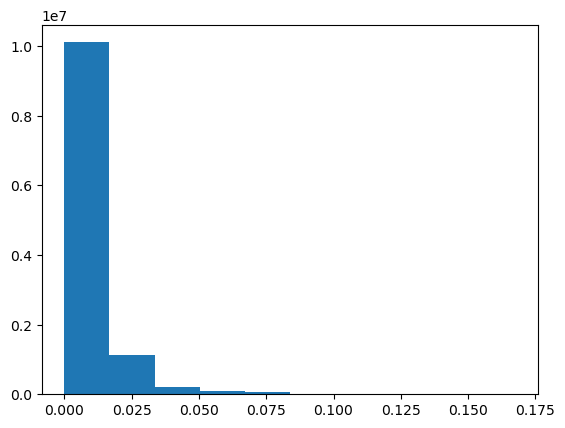

In [56]:
plt.hist(amps_noisy_flattened)

In [57]:
amps_noisy_max = amps_noisy.max(axis=2).max(axis=1)

In [58]:
amps_noisy_max.shape

(10000,)

(array([ 153.,  364., 2132., 2197., 1479., 1392., 1000.,  879.,  345.,
          59.]),
 array([0.04645806, 0.05856623, 0.0706744 , 0.08278256, 0.09489073,
        0.1069989 , 0.11910707, 0.13121524, 0.14332341, 0.15543158,
        0.16753975]),
 <BarContainer object of 10 artists>)

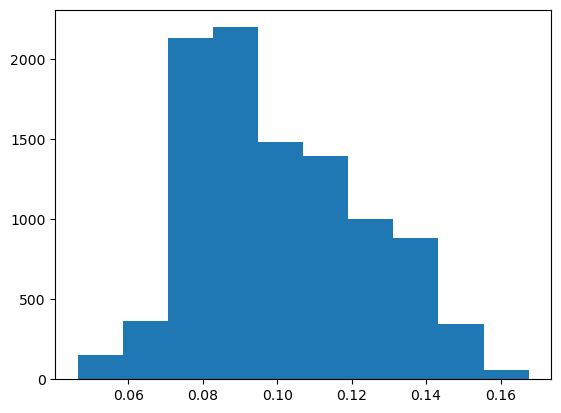

In [59]:
plt.hist(amps_noisy_max)